In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import kagglehub
import os
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
path1 = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")
path2 = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path1)
print("Path to second dataset:", path2)

Using Colab cache for faster access to the 'brain-tumor-classification-mri' dataset.
Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-classification-mri
Path to second dataset: /kaggle/input/brain-tumor-mri-dataset


In [ ]:
dataset_dir1 = os.path.join(path1)
dataset_dir2 = os.path.join(path2)
print("MRI Dataset1", dataset_dir1)
print("MRI Dataset2", dataset_dir2)

print("Folders inside dataset:")
print(os.listdir(dataset_dir1))
print(os.listdir(dataset_dir2))

MRI Dataset1 /kaggle/input/brain-tumor-classification-mri
MRI Dataset2 /kaggle/input/brain-tumor-mri-dataset
Folders inside dataset:
['Training', 'Testing']
['Training', 'Testing']


In [ ]:
print(os.listdir(os.path.join(dataset_dir1, "Training")))
print(os.listdir(os.path.join(dataset_dir2, "Training")))

['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']
['pituitary', 'notumor', 'meningioma', 'glioma']


In [ ]:
combined_dir = "/kaggle/working/Combined_Brain_Tumor_Dataset"
os.makedirs(combined_dir, exist_ok=True)

classes = ['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']
for c in classes:
    os.makedirs(os.path.join(combined_dir, 'Training', c), exist_ok=True)
    os.makedirs(os.path.join(combined_dir, 'Testing', c), exist_ok=True)

In [ ]:
print(os.listdir(os.path.join(combined_dir, "Training")))

['glioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'no_tumor']


In [ ]:
map1 = {
    'no_tumor': 'no_tumor',
    'pituitary_tumor': 'pituitary_tumor',
    'meningioma_tumor': 'meningioma_tumor',
    'glioma_tumor': 'glioma_tumor'
}

map2 = {
    'notumor': 'no_tumor',
    'pituitary': 'pituitary_tumor',
    'meningioma': 'meningioma_tumor',
    'glioma': 'glioma_tumor'
}

def copy_images(src_dir, dest_dir, name_map):
    for cls in os.listdir(src_dir):
        src_class = os.path.join(src_dir, cls)
        if not os.path.isdir(src_class):
            continue
        target_cls = name_map.get(cls)
        if target_cls is None:
            continue

        dest_class = os.path.join(dest_dir, target_cls)
        os.makedirs(dest_class, exist_ok=True)

        for img_name in os.listdir(src_class):
            src_path = os.path.join(src_class, img_name)
            dest_path = os.path.join(dest_class, img_name)
            shutil.copy(src_path, dest_path)


print("Copying Dataset 1...")
copy_images(os.path.join(dataset_dir1, 'Training'), os.path.join(combined_dir, 'Training'), map1)
copy_images(os.path.join(dataset_dir1, 'Testing'), os.path.join(combined_dir, 'Testing'), map1)

print("Copying Dataset 2...")
copy_images(os.path.join(dataset_dir2, 'Training'), os.path.join(combined_dir, 'Training'), map2)
copy_images(os.path.join(dataset_dir2, 'Testing'), os.path.join(combined_dir, 'Testing'), map2)
print("Datasets merged successfully!")

# Check number of images in each class
for split in ['Training', 'Testing']:
    print(f"\n{split} set:")
    for cls in os.listdir(os.path.join(combined_dir, split)):
        path_class = os.path.join(combined_dir, split, cls)
        print(f"{cls}: {len(os.listdir(path_class))} images")

Copying Dataset 1...
Copying Dataset 2...
Datasets merged successfully!

Training set:
glioma_tumor: 2147 images
pituitary_tumor: 2284 images
meningioma_tumor: 2161 images
no_tumor: 1990 images

Testing set:
glioma_tumor: 400 images
pituitary_tumor: 374 images
meningioma_tumor: 421 images
no_tumor: 510 images


In [ ]:
train_data = datasets.ImageFolder(os.path.join(combined_dir, 'Training'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(combined_dir, 'Testing'), transform=test_transform)

In [ ]:
print("Total training images:", len(train_data))
print("Classes:", train_data.classes)

Total training images: 8582
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [ ]:
image, label = train_data[200]
print("Image shape:", image.shape)
print("Label:", label, ",for class:", train_data.classes[label])

Image shape: torch.Size([3, 224, 224])
Label: 0 ,for class: glioma_tumor


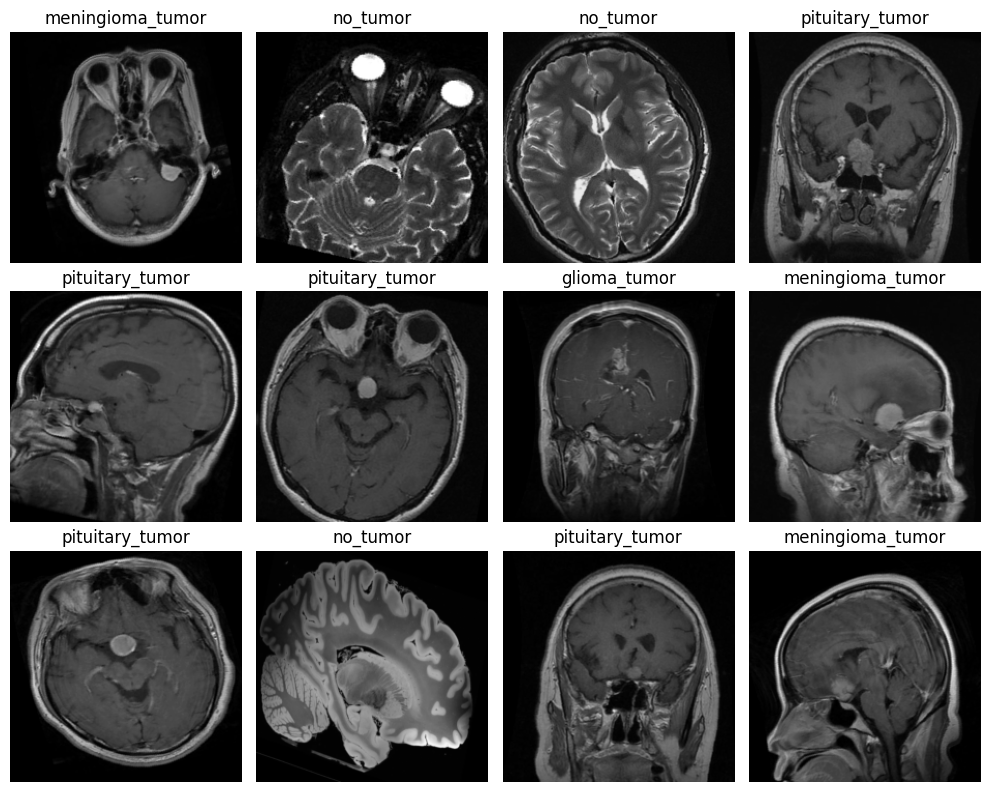

In [ ]:
def denormalize(img_tensor):
    img = img_tensor * 0.5 + 0.5
    img = torch.clamp(img, 0, 1)
    return img

fig, axes = plt.subplots(3, 4, figsize=(10, 8))

for ax in axes.flatten():
    idx = torch.randint(0, len(train_data), (1,)).item()
    img, label = train_data[idx]
    img = denormalize(img)
    img = img.permute(1, 2, 0)
    ax.imshow(img)
    ax.set_title(train_data.classes[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)


print(images.shape)
print(labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [ ]:
effnet = models.efficientnet_b0(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 122MB/s]


In [ ]:
for parm in effnet.features[:7].parameters():
    parm.requires_grad = False # they will be freezed

for parm in effnet.features[7:].parameters():
    parm.requires_grad = True  # they will be fine-tuned


num_classes = 4
effnet.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features=1280, out_features=512, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=512, out_features=num_classes, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer_effnet = optim.Adam(effnet.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_effnet, mode='min', factor=0.5, patience=3)

In [ ]:
writer_eff = SummaryWriter(log_dir="runs/EFFNet")

In [ ]:
def train_model(model, criterion, optimizer, scheduler, writer, trainloader, testloader, epochs=30, name="Model"):
    best_acc = 0
    patience = 5
    counter = 0

    history = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}

    model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(trainloader, desc=f"{name} | Epoch {epoch+1}/{epochs}")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loop.set_postfix(loss=f"{loss.item():.4f}", acc=f"{100*correct/total:.2f}%")

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total

        model.eval()
        test_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss /= len(testloader)
        test_acc = 100 * correct / total
        scheduler.step(test_loss)

        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)

        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Test", test_loss, epoch)
        writer.add_scalar("Accuracy/Train", train_acc, epoch)
        writer.add_scalar("Accuracy/Test", test_acc, epoch)

        print(f"{name} | Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), f"{name}_best.pth")
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    writer.close()
    print(f"Training complete for {name} | Best Acc: {best_acc:.2f}%")
    return model,history

In [ ]:
model , history_eff = train_model(effnet, criterion, optimizer_effnet, scheduler, writer_eff, trainloader, testloader, epochs=30, name="EfficientNetB0")

EfficientNetB0 | Epoch 1/30: 100%|██████████| 269/269 [01:16<00:00,  3.52it/s, acc=79.31%, loss=0.4847]


EfficientNetB0 | Epoch [1/30] Train Loss: 0.6143, Train Acc: 79.31% | Test Loss: 0.5583, Test Acc: 78.65%


EfficientNetB0 | Epoch 2/30: 100%|██████████| 269/269 [01:15<00:00,  3.55it/s, acc=89.31%, loss=0.3759]


EfficientNetB0 | Epoch [2/30] Train Loss: 0.2942, Train Acc: 89.31% | Test Loss: 0.4541, Test Acc: 85.34%


EfficientNetB0 | Epoch 3/30: 100%|██████████| 269/269 [01:14<00:00,  3.62it/s, acc=91.76%, loss=0.2580]


EfficientNetB0 | Epoch [3/30] Train Loss: 0.2266, Train Acc: 91.76% | Test Loss: 0.3989, Test Acc: 88.09%


EfficientNetB0 | Epoch 4/30: 100%|██████████| 269/269 [01:13<00:00,  3.65it/s, acc=93.11%, loss=0.2895]


EfficientNetB0 | Epoch [4/30] Train Loss: 0.1878, Train Acc: 93.11% | Test Loss: 0.3843, Test Acc: 88.97%


EfficientNetB0 | Epoch 5/30: 100%|██████████| 269/269 [01:14<00:00,  3.60it/s, acc=93.79%, loss=0.5579]


EfficientNetB0 | Epoch [5/30] Train Loss: 0.1618, Train Acc: 93.79% | Test Loss: 0.4253, Test Acc: 89.03%


EfficientNetB0 | Epoch 6/30: 100%|██████████| 269/269 [01:13<00:00,  3.64it/s, acc=94.73%, loss=0.3578]


EfficientNetB0 | Epoch [6/30] Train Loss: 0.1358, Train Acc: 94.73% | Test Loss: 0.3581, Test Acc: 91.55%


EfficientNetB0 | Epoch 7/30: 100%|██████████| 269/269 [01:14<00:00,  3.63it/s, acc=95.16%, loss=0.3910]


EfficientNetB0 | Epoch [7/30] Train Loss: 0.1294, Train Acc: 95.16% | Test Loss: 0.3605, Test Acc: 92.67%


EfficientNetB0 | Epoch 8/30: 100%|██████████| 269/269 [01:13<00:00,  3.67it/s, acc=96.03%, loss=0.3999]


EfficientNetB0 | Epoch [8/30] Train Loss: 0.1092, Train Acc: 96.03% | Test Loss: 0.3900, Test Acc: 92.90%


EfficientNetB0 | Epoch 9/30: 100%|██████████| 269/269 [01:16<00:00,  3.52it/s, acc=96.35%, loss=0.7113]


EfficientNetB0 | Epoch [9/30] Train Loss: 0.1004, Train Acc: 96.35% | Test Loss: 0.3576, Test Acc: 93.02%


EfficientNetB0 | Epoch 10/30: 100%|██████████| 269/269 [01:13<00:00,  3.65it/s, acc=96.35%, loss=1.2491]


EfficientNetB0 | Epoch [10/30] Train Loss: 0.0967, Train Acc: 96.35% | Test Loss: 0.3374, Test Acc: 93.84%


EfficientNetB0 | Epoch 11/30: 100%|██████████| 269/269 [01:13<00:00,  3.65it/s, acc=96.80%, loss=0.0264]


EfficientNetB0 | Epoch [11/30] Train Loss: 0.0872, Train Acc: 96.80% | Test Loss: 0.3861, Test Acc: 92.84%


EfficientNetB0 | Epoch 12/30: 100%|██████████| 269/269 [01:13<00:00,  3.66it/s, acc=97.24%, loss=0.8781]


EfficientNetB0 | Epoch [12/30] Train Loss: 0.0853, Train Acc: 97.24% | Test Loss: 0.3749, Test Acc: 93.49%


EfficientNetB0 | Epoch 13/30: 100%|██████████| 269/269 [01:13<00:00,  3.66it/s, acc=97.55%, loss=0.0121]


EfficientNetB0 | Epoch [13/30] Train Loss: 0.0688, Train Acc: 97.55% | Test Loss: 0.3646, Test Acc: 93.96%


EfficientNetB0 | Epoch 14/30: 100%|██████████| 269/269 [01:13<00:00,  3.66it/s, acc=97.96%, loss=0.0171]


EfficientNetB0 | Epoch [14/30] Train Loss: 0.0616, Train Acc: 97.96% | Test Loss: 0.3525, Test Acc: 93.55%


EfficientNetB0 | Epoch 15/30: 100%|██████████| 269/269 [01:14<00:00,  3.62it/s, acc=98.00%, loss=0.0035]


EfficientNetB0 | Epoch [15/30] Train Loss: 0.0568, Train Acc: 98.00% | Test Loss: 0.3689, Test Acc: 93.55%


EfficientNetB0 | Epoch 16/30: 100%|██████████| 269/269 [01:14<00:00,  3.62it/s, acc=98.01%, loss=0.0287]


EfficientNetB0 | Epoch [16/30] Train Loss: 0.0541, Train Acc: 98.01% | Test Loss: 0.3728, Test Acc: 93.67%


EfficientNetB0 | Epoch 17/30: 100%|██████████| 269/269 [01:14<00:00,  3.62it/s, acc=98.04%, loss=1.5533]


EfficientNetB0 | Epoch [17/30] Train Loss: 0.0604, Train Acc: 98.04% | Test Loss: 0.3825, Test Acc: 93.84%


EfficientNetB0 | Epoch 18/30: 100%|██████████| 269/269 [01:14<00:00,  3.62it/s, acc=98.28%, loss=0.0903]


EfficientNetB0 | Epoch [18/30] Train Loss: 0.0492, Train Acc: 98.28% | Test Loss: 0.3607, Test Acc: 94.19%


EfficientNetB0 | Epoch 19/30: 100%|██████████| 269/269 [01:14<00:00,  3.61it/s, acc=98.44%, loss=0.3744]


EfficientNetB0 | Epoch [19/30] Train Loss: 0.0476, Train Acc: 98.44% | Test Loss: 0.3911, Test Acc: 94.02%


EfficientNetB0 | Epoch 20/30: 100%|██████████| 269/269 [01:15<00:00,  3.58it/s, acc=98.59%, loss=0.1213]


EfficientNetB0 | Epoch [20/30] Train Loss: 0.0449, Train Acc: 98.59% | Test Loss: 0.3856, Test Acc: 94.13%


EfficientNetB0 | Epoch 21/30: 100%|██████████| 269/269 [01:14<00:00,  3.61it/s, acc=98.59%, loss=0.0807]


EfficientNetB0 | Epoch [21/30] Train Loss: 0.0402, Train Acc: 98.59% | Test Loss: 0.3645, Test Acc: 94.08%


EfficientNetB0 | Epoch 22/30: 100%|██████████| 269/269 [01:12<00:00,  3.69it/s, acc=98.79%, loss=0.3637]


EfficientNetB0 | Epoch [22/30] Train Loss: 0.0417, Train Acc: 98.79% | Test Loss: 0.3672, Test Acc: 94.19%


EfficientNetB0 | Epoch 23/30: 100%|██████████| 269/269 [01:12<00:00,  3.69it/s, acc=98.47%, loss=0.0033]


EfficientNetB0 | Epoch [23/30] Train Loss: 0.0430, Train Acc: 98.47% | Test Loss: 0.3374, Test Acc: 94.49%


EfficientNetB0 | Epoch 24/30: 100%|██████████| 269/269 [01:13<00:00,  3.68it/s, acc=98.73%, loss=0.0415]


EfficientNetB0 | Epoch [24/30] Train Loss: 0.0349, Train Acc: 98.73% | Test Loss: 0.3517, Test Acc: 94.60%


EfficientNetB0 | Epoch 25/30: 100%|██████████| 269/269 [01:13<00:00,  3.68it/s, acc=98.58%, loss=0.0190]


EfficientNetB0 | Epoch [25/30] Train Loss: 0.0406, Train Acc: 98.58% | Test Loss: 0.3561, Test Acc: 94.19%


EfficientNetB0 | Epoch 26/30: 100%|██████████| 269/269 [01:14<00:00,  3.63it/s, acc=98.83%, loss=0.1325]


EfficientNetB0 | Epoch [26/30] Train Loss: 0.0388, Train Acc: 98.83% | Test Loss: 0.3851, Test Acc: 94.49%


EfficientNetB0 | Epoch 27/30: 100%|██████████| 269/269 [01:23<00:00,  3.22it/s, acc=98.57%, loss=0.2006]


EfficientNetB0 | Epoch [27/30] Train Loss: 0.0421, Train Acc: 98.57% | Test Loss: 0.3509, Test Acc: 94.60%


EfficientNetB0 | Epoch 28/30: 100%|██████████| 269/269 [01:15<00:00,  3.58it/s, acc=98.78%, loss=0.0189]


EfficientNetB0 | Epoch [28/30] Train Loss: 0.0357, Train Acc: 98.78% | Test Loss: 0.3821, Test Acc: 94.25%


EfficientNetB0 | Epoch 29/30: 100%|██████████| 269/269 [01:13<00:00,  3.66it/s, acc=98.61%, loss=0.0119]


EfficientNetB0 | Epoch [29/30] Train Loss: 0.0379, Train Acc: 98.61% | Test Loss: 0.3697, Test Acc: 94.25%
Early stopping at epoch 29
Training complete for EfficientNetB0 | Best Acc: 94.60%


40min d'entrainement!

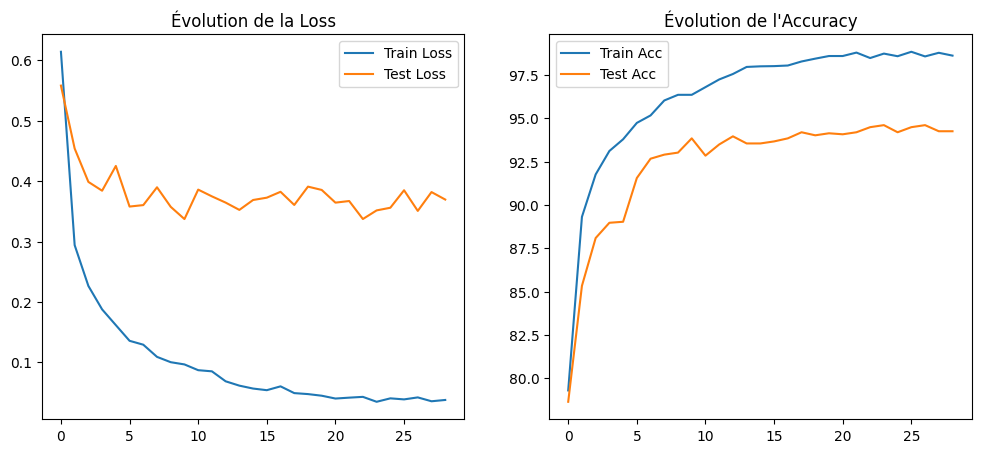

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_eff["train_loss"], label="Train Loss")
plt.plot(history_eff["test_loss"], label="Test Loss")
plt.legend(); plt.title("Évolution de la Loss")

plt.subplot(1,2,2)
plt.plot(history_eff["train_acc"], label="Train Acc")
plt.plot(history_eff["test_acc"], label="Test Acc")
plt.legend(); plt.title("Évolution de l'Accuracy")
plt.show()


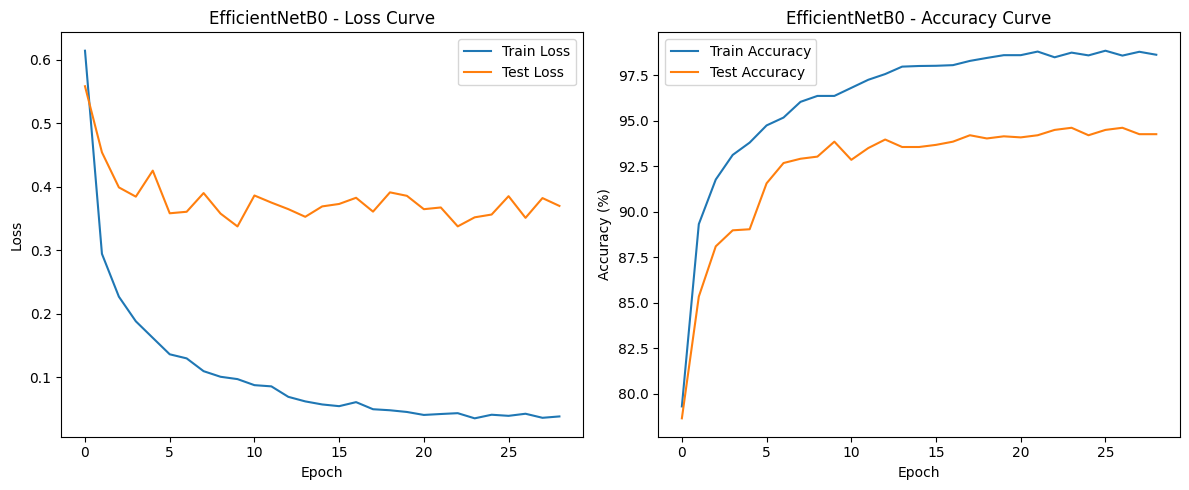

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_eff["train_loss"], label="Train Loss")
plt.plot(history_eff["test_loss"], label="Test Loss")
plt.title("EfficientNetB0 - Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_eff["train_acc"], label="Train Accuracy")
plt.plot(history_eff["test_acc"], label="Test Accuracy")
plt.title("EfficientNetB0 - Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), f"best.pth")


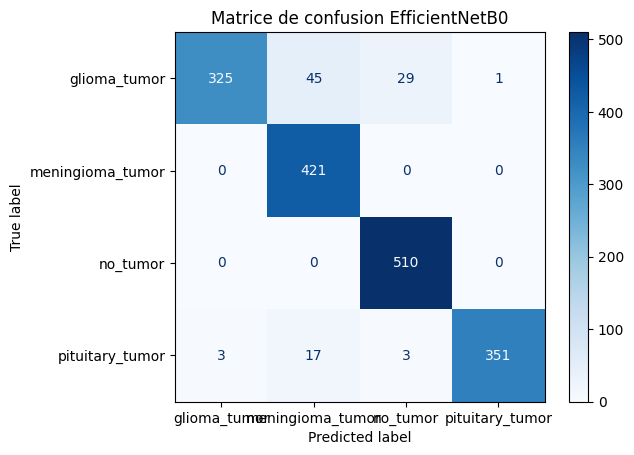

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap='Blues')
plt.title("Matrice de confusion EfficientNetB0")
plt.show()


In [ ]:
import torch
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, r2_score

model = effnet.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [ ]:
from sklearn.metrics import classification_report

print("=== Rapport complet ===")
print(classification_report(all_labels, all_preds, target_names=train_data.classes))


=== Rapport complet ===
                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.81      0.89       400
meningioma_tumor       0.87      1.00      0.93       421
        no_tumor       0.94      1.00      0.97       510
 pituitary_tumor       1.00      0.94      0.97       374

        accuracy                           0.94      1705
       macro avg       0.95      0.94      0.94      1705
    weighted avg       0.95      0.94      0.94      1705



In [ ]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=acbc944f221830c10f05b6b3d78c58c35706ddfdcecf5da4f7161e81802a5597
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [ ]:

effnet.eval()

images, labels = next(iter(testloader))
idx = np.random.randint(len(images))
image = images[idx].unsqueeze(0).to(device)
true_label = labels[idx].item()


Prédiction du modèle

In [ ]:
with torch.no_grad():
    outputs = effnet(image)
    probs = torch.softmax(outputs, dim=1)
    pred_class = torch.argmax(probs, 1).item()
    pred_conf = probs[0, pred_class].item()

Conversion image pour affichage

In [ ]:
rgb_img = images[idx].permute(1, 2, 0).cpu().numpy()
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

Grad-CAM

In [ ]:
target_layers = [effnet.features[-1]]
cam = GradCAM(model=effnet, target_layers=target_layers)
targets = [ClassifierOutputTarget(pred_class)]
grayscale_cam = cam(input_tensor=image, targets=targets)[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

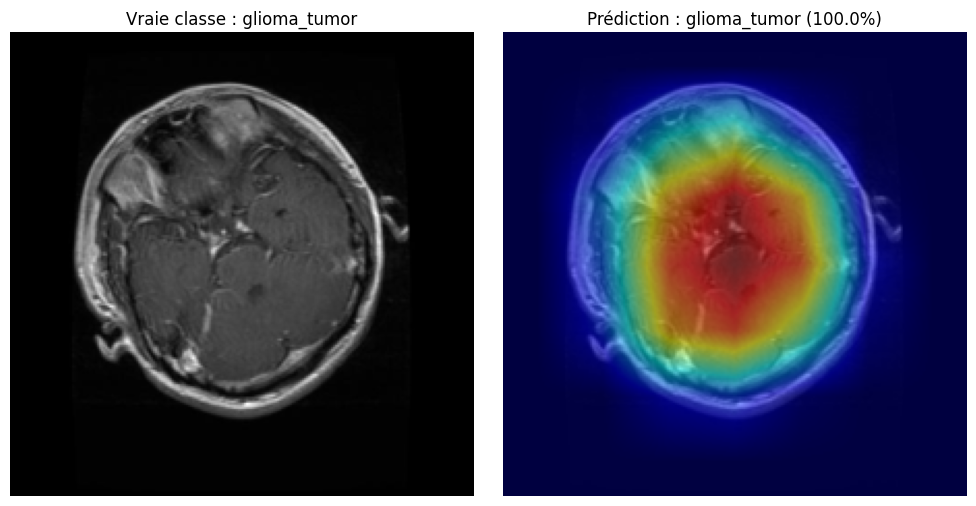

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(rgb_img)
plt.title(f"Vraie classe : {train_data.classes[true_label]}")
plt.axis("off")

# Image Grad-CAM + infos prédiction
plt.subplot(1,2,2)
plt.imshow(visualization)
plt.title(f"Prédiction : {train_data.classes[pred_class]} ({pred_conf*100:.1f}%)")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:

effnet.eval()

# On récupère un index aléatoire global sur tout le dataset
rand_idx = np.random.randint(len(test_data))

# On récupère l'image et son label directement depuis le dataset
image, label = test_data[rand_idx]

# Préparation pour le modèle
image = image.unsqueeze(0).to(device)
true_label = label


In [ ]:
with torch.no_grad():
    outputs = effnet(image)
    probs = torch.softmax(outputs, dim=1)
    pred_class = torch.argmax(probs, 1).item()
    pred_conf = probs[0, pred_class].item()

rgb_img = images[idx].permute(1, 2, 0).cpu().numpy()
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())


In [ ]:
target_layers = [effnet.features[-1]]
cam = GradCAM(model=effnet, target_layers=target_layers)
targets = [ClassifierOutputTarget(pred_class)]
grayscale_cam = cam(input_tensor=image, targets=targets)[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

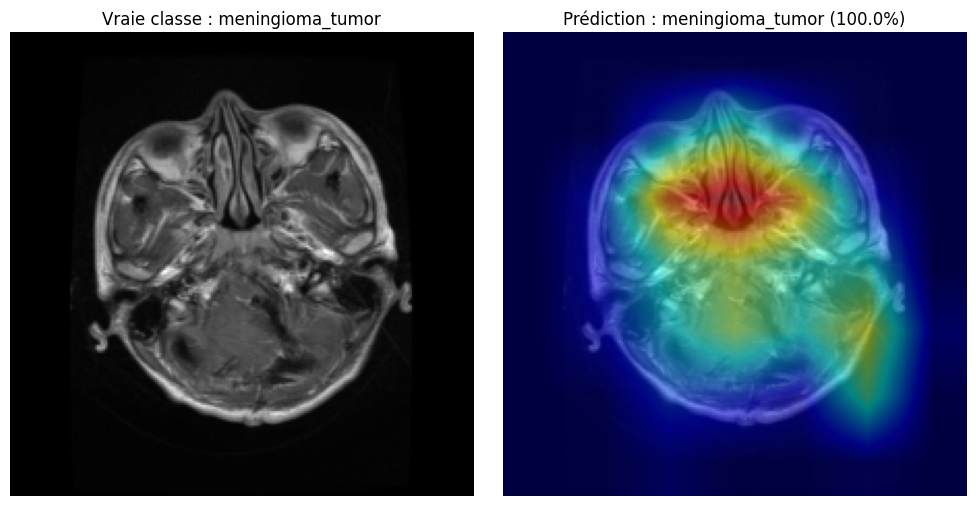

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(rgb_img)
plt.title(f"Vraie classe : {train_data.classes[true_label]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(visualization)
plt.title(f"Prédiction : {train_data.classes[pred_class]} ({pred_conf*100:.1f}%)")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:

effnet.eval()

rand_idx = np.random.randint(len(test_data))

image, label = test_data[rand_idx]

image = image.unsqueeze(0).to(device)
true_label = label


In [ ]:
with torch.no_grad():
    outputs = effnet(image)
    probs = torch.softmax(outputs, dim=1)
    pred_class = torch.argmax(probs, 1).item()
    pred_conf = probs[0, pred_class].item()

rgb_img = images[idx].permute(1, 2, 0).cpu().numpy()
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())


In [ ]:
target_layers = [effnet.features[-1]]
cam = GradCAM(model=effnet, target_layers=target_layers)
targets = [ClassifierOutputTarget(pred_class)]
grayscale_cam = cam(input_tensor=image, targets=targets)[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

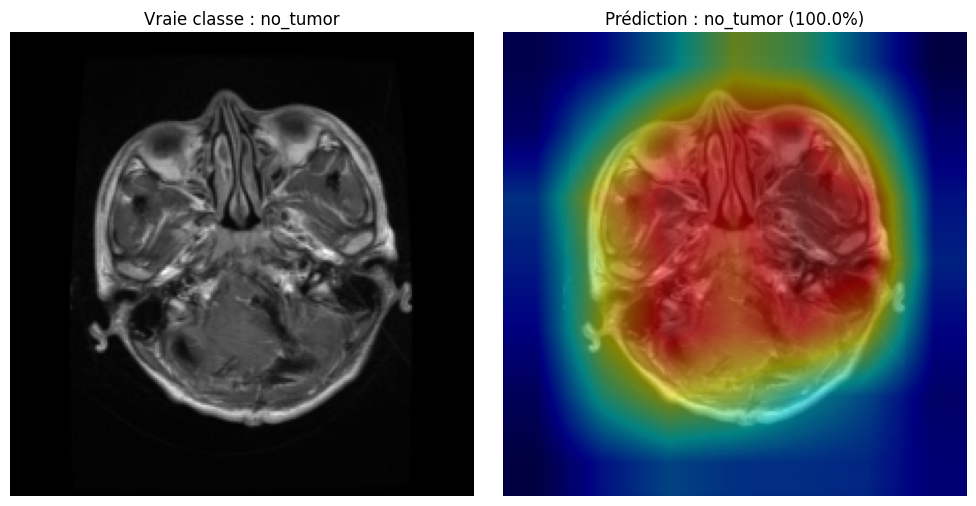

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(rgb_img)
plt.title(f"Vraie classe : {train_data.classes[true_label]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(visualization)
plt.title(f"Prédiction : {train_data.classes[pred_class]} ({pred_conf*100:.1f}%)")
plt.axis("off")

plt.tight_layout()
plt.show()